# Jeopardy NLP

Essentially in this notebook I wish to accomplish the following:

  1. topic modeling of the jeopardy questions
  1. search the questions database intelligently
  1. estimate the dollar-value of a user-generated question

# Load Modules & Data

In [19]:
import re

import pandas as pd
import numpy as np

import spacy
from spacy.lemmatizer import Lemmatizer

import gensim 
from gensim.models import Word2Vec 

import sklearn
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import scipy
from scipy.linalg import svd

import fbpca

import matplotlib.pyplot as plt

modules = [gensim, np, pd, scipy, sklearn, spacy]

for module in modules:
    print(f'{module.__name__}: {module.__version__}')

gensim: 3.4.0
numpy: 1.16.4
pandas: 0.24.2
scipy: 1.3.0
sklearn: 0.21.2
spacy: 2.1.8


In [2]:
data = pd.read_json('data/JEOPARDY_QUESTIONS1.json')
data.head()

,air_date,answer,category,question,round,show_number,value
0,2004-12-31,Copernicus,HISTORY,"'For the last 8 years of his life, Galileo was...",Jeopardy!,4680,$200
1,2004-12-31,Jim Thorpe,ESPN's TOP 10 ALL-TIME ATHLETES,'No. 2: 1912 Olympian; football star at Carlis...,Jeopardy!,4680,$200
2,2004-12-31,Arizona,EVERYBODY TALKS ABOUT IT...,'The city of Yuma in this state has a record a...,Jeopardy!,4680,$200
3,2004-12-31,McDonald\'s,THE COMPANY LINE,"'In 1963, live on ""The Art Linkletter Show"", t...",Jeopardy!,4680,$200
4,2004-12-31,John Adams,EPITAPHS & TRIBUTES,"'Signer of the Dec. of Indep., framer of the C...",Jeopardy!,4680,$200


# Clean the Data

## For the Questions

1. Remove HTML tags that appear sometimes. These are usually just links to pictures it looks like.
2. The questions are all in quotes, which is kind of annoying

In [3]:
strip_html = re.compile(r'<.*?>')

data.question = data.question.map(lambda x : strip_html.sub('',x))

In [4]:
data.question = data.question.map(lambda x : x[1:-1] + " ")

In [5]:
data.question.sample(10)

65202                                      Loud speaker(6) 
191570    In 1666 this Quaker who founded an American co...
86591     Compounds featuring this element are used to t...
29115     Imperial New York state nickname for a time of...
81898     Bouffee or souffle in French, it's found befor...
51798     Covered mostly by an inland icecap, the world'...
152439    In the 1800s Argentinean cowboys called this i...
31117     1 potato, 2 potato, 3 potato, 4, more potatoes...
123127    In 1570 Spain's Phillip II tried to put this q...
132582    An Asian deer secretes this substance commonly...
Name: question, dtype: object

# Topic Modeling

This will be following the [Fast.AI](https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb) course using SVD for LDA. To speed up the computation, I am using Facebook's `fbpca` package to perform randomized SVD which produces similar results in far less time.

Because these are not very complex models, I will be processing the data.

Furthermore, SVD performs poorly on short texts, so I have taken all questions from each category and concatenated them to assist the learner.

This leads to meaningful categories, as is demonstrated in the final cell of this section.

In [6]:
# just a quick method to sample random elements from something iterable
def sample(arr, n=10):
    if n == 'all':
        return arr
    return arr[np.random.randint(0,len(arr),size=n)]

In [7]:
questions = data[['category','question']].groupby(by='category').sum().question

In [8]:
vectorizer = CountVectorizer(stop_words='english')

vectors = vectorizer.fit_transform(questions)

In [9]:
vectors

<27995x87566 sparse matrix of type '<class 'numpy.int64'>'
	with 1445283 stored elements in Compressed Sparse Row format>

In [10]:
vocab = np.array(vectorizer.get_feature_names())
print(vocab.shape)
print(sample(vocab))

(87566,)
['atlantico' 'relics' 'valved' 'zuiderzee' 'buffoon' 'presently' 'wacky'
 'bureaucrats' 'ambrosia' 'welch']


In [11]:
U, s, Vh = fbpca.pca(vectors, 30)

In [12]:
print(U.shape, s.shape, Vh.shape)

(27995, 30) (30,) (30, 87566)


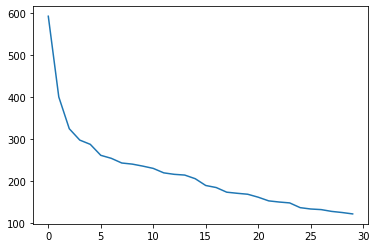

In [13]:
plt.plot(s)

In [14]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [15]:
show_topics(Vh[:8])

['city capital state country named new island largest',
 'novel wrote title author book man film called',
 'novel city capital title author wrote book film',
 'state university word school college clue type crew',
 'word capital city comes latin type used clue',
 'film country ballet played president opera museum king',
 'language university country school spoken college official languages',
 'state language film capital spoken ballet official opera']

In [16]:
data.question.iloc[1300]

"A Shakespeare sonnet accuses this purple flower of steaing its smell from the poet's love "

In [17]:
vectorizer.transform([data.question.iloc[1300]])

<1x87566 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

# Topic Modeling With Gensim

In [18]:
nlp = spacy.load('en')